# Demo : plaintext sigmoid tests

In [131]:
import numpy as np
import matplotlib.pyplot as plt

import sys
import os
sys.path.append(os.path.abspath('..'))
from src.config import setup_logging
logger = setup_logging("DEBUG")

from src.data.data_utils import load_data, num_to_data_path, train_test_split, stack_and_scale
from src.data.preprocessing import bin_to_pm1, add_bias, init_wv
from src.data.scalers import MaxAbsScaler, MinMaxScaler, StandardScaler

from src.sigmoid import get_sigmoid_approx
from src.nag_momentum import NAGUpdater

from src.models.logreg_pt_sigmoid import LogisticRegressionIDASH
from src.metrics import print_classification_metrics, calculate_acc_auc_idash_style, beta_to_loss_history, plot_loss_evolution, plot_proba_distrib


In [132]:
# Parameters
dataset_num = 6

n_epoch = 7
gamma_up = 10
gamma_down = -1

use_nag = True
scaler = MaxAbsScaler()     # MaxAbsScaler(), MinMaxScaler(), StandardScaler()
beta_init_method = "mean-idash"   # mean, zero, random
nag_smooth_method = NAGUpdater('idash')

degree = 5  # 3, 5, 7
true_sigmoid = get_sigmoid_approx()
minus_sigmoid = get_sigmoid_approx("minus_sigmoid")
sigmoid = get_sigmoid_approx("least_squares", degree=degree)

DEBUG - Getting sigmoid approximation: method=sigmoid, degree=0, encrypted=False
DEBUG - Getting sigmoid approximation: method=minus_sigmoid, degree=0, encrypted=False
DEBUG - Getting sigmoid approximation: method=least_squares, degree=5, encrypted=False


## Load data and preprocessing

In [133]:
X, y_bin = load_data(num_to_data_path(dataset_num))

INFO - Loading data from ../data/uis.txt
INFO - Loaded dataset with 575 samples and 8 features


In [134]:
# iDASH
X_train, X_test, y_bin_train, y_bin_test = train_test_split(X, y_bin, test_size=0.2)

Z_train_ = bin_to_pm1(y_bin_train)[:, np.newaxis] * add_bias(X_train)
Z_test_ = bin_to_pm1(y_bin_test)[:, np.newaxis] * add_bias(X_test)

Z_train, Z_test = stack_and_scale(scaler, Z_train_, Z_test_)

w, v = init_wv(Z_train, method=beta_init_method)

INFO - Splitting data into train/test sets
DEBUG - Train size: 460, Test size: 115
INFO - Adding bias term
DEBUG - Added bias term: (460, 8) -> (460, 9)
INFO - Adding bias term
DEBUG - Added bias term: (115, 8) -> (115, 9)
INFO - Stacking and scaling data
DEBUG - Scaled rang: [-1.0, 1.0]
INFO - Initializing weights for 9 features as: 'mean-idash'
DEBUG - Weight stats - Min: 0.0001, Max: 0.0010, Mean: 0.0005


In [135]:
# # iDASH corrected
# X_ = add_bias(X)

# X_train, X_test, y_bin_train, y_bin_test = train_test_split(X_, y_bin, test_size=0.2)

# Z_train = scaler.fit_transform(X_train)
# Z_test = scaler.transform(X_test)

# Z_train = bin_to_pm1(y_bin_train)[:, np.newaxis] * Z_train

# w, v = init_wv(Z_train, method=beta_init_method)

## Logistic regression

In [136]:

model_no_nag = LogisticRegressionIDASH(
    sigmoid=sigmoid,
    use_NAG=use_nag,
    nag_momentum_update=nag_smooth_method
)
model_no_nag.fit(
    Z_train, Z_train.shape,
    w,
    n_epoch=n_epoch,
    gamma_up=gamma_up,
    gamma_down=gamma_down,
    pt_v=v
)

INFO - >>> Epoch 1 <<<
DEBUG - Learning rate: 5.0000 - Smoothing parameter: 0.0
DEBUG - lsq input: [-0.0037, 0.0038]
DEBUG - lsq approx: [0.4993, 0.5007]
INFO - >>> Epoch 2 <<<
DEBUG - Learning rate: 3.3333 - Smoothing parameter: -0.28175352512532087
DEBUG - lsq input: [-4.7489, 4.7962]
DEBUG - lsq approx: [-0.0183, 1.0183]
INFO - >>> Epoch 3 <<<
DEBUG - Learning rate: 2.5000 - Smoothing parameter: -0.434042782780302
DEBUG - lsq input: [-1.0087, 1.0213]
DEBUG - lsq approx: [0.3095, 0.6883]
INFO - >>> Epoch 4 <<<
DEBUG - Learning rate: 2.0000 - Smoothing parameter: -0.5310638054044795
DEBUG - lsq input: [-2.3996, 2.4266]
DEBUG - lsq approx: [0.0980, 0.8988]
INFO - >>> Epoch 5 <<<
DEBUG - Learning rate: 1.6667 - Smoothing parameter: -0.5987785940560388
DEBUG - lsq input: [-1.8939, 1.9176]
DEBUG - lsq approx: [0.1645, 0.8321]
INFO - >>> Epoch 6 <<<
DEBUG - Learning rate: 1.4286 - Smoothing parameter: -0.6489233261224006
DEBUG - lsq input: [-1.9939, 2.0198]
DEBUG - lsq approx: [0.1501, 0.8

## Analysis

### Train

DEBUG - lsq input: [-0.0037, 0.0038]
DEBUG - lsq approx: [0.4993, 0.5007]
DEBUG - lsq input: [-4.7489, 4.7962]
DEBUG - lsq approx: [-0.0183, 1.0183]
DEBUG - lsq input: [-1.8191, 1.8391]
DEBUG - lsq approx: [0.1759, 0.8212]
DEBUG - lsq input: [-2.2239, 2.2488]
DEBUG - lsq approx: [0.1197, 0.8771]
DEBUG - lsq input: [-2.0084, 2.0325]
DEBUG - lsq approx: [0.1483, 0.8483]
DEBUG - lsq input: [-1.9993, 2.0246]
DEBUG - lsq approx: [0.1494, 0.8471]
DEBUG - lsq input: [-2.0350, 2.0618]
DEBUG - lsq approx: [0.1443, 0.8520]
DEBUG - lsq input: [-2.0694, 2.1090]
DEBUG - lsq approx: [0.1379, 0.8567]


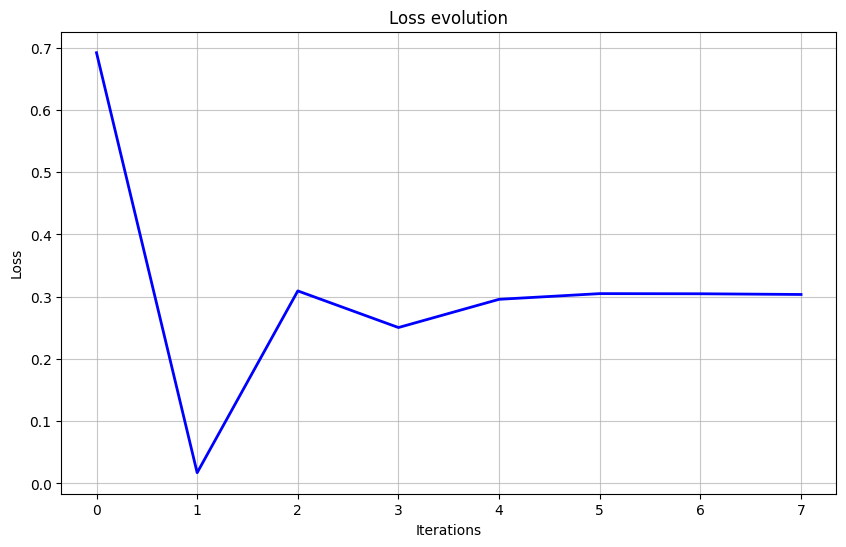

In [137]:
beta_history = np.concatenate([[w], model_no_nag.beta_history])
loss_history = beta_to_loss_history(beta_history, Z_train, y_bin_train, sigmoid)
plot_loss_evolution(loss_history)

### Test

In [138]:
w_trained = model_no_nag.pt_beta
proba = model_no_nag.predict_proba(Z_test, w_trained, sigmoid=sigmoid)
print_classification_metrics(
    y_bin_test, proba
)

DEBUG - lsq input: [-2.0037, 2.0761]
DEBUG - lsq approx: [0.1424, 0.8477]



ACC: 1.0000
AUC: 1.0000
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        30
         1.0       1.00      1.00      1.00        85

    accuracy                           1.00       115
   macro avg       1.00      1.00      1.00       115
weighted avg       1.00      1.00      1.00       115

[[30  0]
 [ 0 85]]

MSE: 0.0000
NMSE: 0.0000



(np.float64(1.0), 1.0)

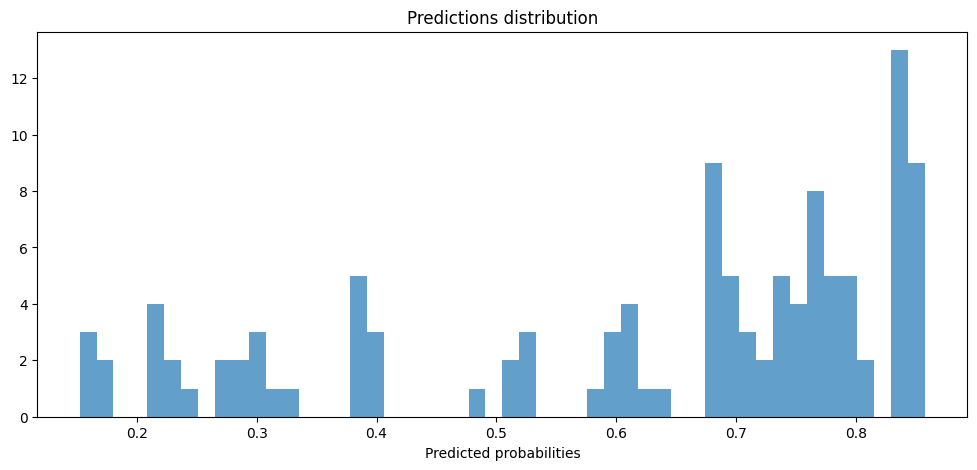

In [139]:
plot_proba_distrib(proba)

In [140]:
calculate_acc_auc_idash_style(Z_test, w_trained)

ACC: 73.9130 %.
AUC: 0.5910


(73.91304347826087, 0.5909803921568627)